# Algorithms for training sparse regression models

In many (machine) learning tasks, we have access to a great number of input features, whose impact on the learner's output is in turn controlled by one or more parameters that the learning algorithm must tune. In reality, however, a *sparse* solution, in which the effects of most features are null, is often more useful.

__Contents:__

- <a href="#background">Basic background</a>
- <a href="#coorddesc">Under the squared loss: coordinate descent</a>
- <a href="#robust">Robust sparse regression</a>

___

Having set up the basic machinery for iterative algorithms in previous lessons, in this lesson we implement procedures which are designed to enforce a certain (controllable) degree of sparseness on the algorithm output.

<a id="background"></a>
## Basic background

In the now-classic words of R. Tibshirani (1996), there are two important reasons for seeking out sparse solutions when we have many parameters (often more than the number of samples). One is *prediction accuracy*:

> _"[Naive estimates] often have low bias but large variance; prediction accuracy can sometimes be improved by shrinking or setting to 0 some coefficients."_

Another reason is is *interpretation*:

> _"With a large number of predictors, we often would like to determine a smaller subset that exhibits the strongest effects."_

Indeed, consider the plethora of stimulus that the human brain encounters in daily activities. Despite the richness of this input, measurement of brain activity reflects a certain degree of "selectivity" towards certain stimulus (image via Haxby et al., 2001):

<img src="img/fmri_response.jpg" alt="Image source: Haxby et al. (2001)" width="480"/>

When statistical learning procedures are carried out by machines, and they have access to a large number of input features, we must take measures to ensure that the solutions they arrive at are sufficiently sparse.

<img src="img/sparse_matrix.png" alt="Image: Sparse matrix image" width="240"/>

While the notion of sparsity is inherently model-dependent, most are formulated such that parameters with a value of $0$ correspond to a certain feature having null impact. Thus, if our parameter vector $w \in \mathbb{R}^{d}$ contains a large number of zeros while performing as desired, then it is a good sparse solution. Most directly, the $\ell_{0}$ norm measures this as

\begin{align}
\|w\|_{0} = \left|\{j \in [d]: w_{j} \neq 0\}\right|.
\end{align}

In the risk minimization setting then, where $R(w) = \mathbf{E}_{Z} l(w;z)$, the ideal objective would be something like

\begin{align}
\min_{w \in \mathbb{R}^{d}} R(w), \quad \text{s.t. } \|w\|_{0} \leq \gamma_{0}.
\end{align}

This is computationally very challenging, but a rich literature from both the statistics and signal processing communities has demonstrated that one can achieve a small $\ell_{0}$ norm by pursuing a small enough $\ell_{1}$ norm. Changing this condition we get

\begin{align}
\min_{w \in \mathbb{R}^{d}} R(w), \quad \text{s.t. } \|w\|_{1} \leq \gamma_{1}
\end{align}

as an ideal routine, and in practice a natural approach is to attempt to minimize

\begin{align}
L_{\lambda}(w) = \frac{1}{n}\sum_{i=1}^{n} l(w;z_{i}) + \lambda \sum_{j=1}^{d}|w_{j}|.
\end{align}

It is from this point in our formulation that we begin to dig into specific algorithms.

___

<a id="coorddesc"></a>
## Under the squared loss: coordinate descent

Perhaps the canonical scenario of interest is the "least-squares linear regression" model, namely the setting where

\begin{align}
l(w;z) = (y-w^{T}x)^{2}, \quad z=(x,y) \in \mathbb{R}^{d+1}.
\end{align}

The objective function then takes the form

\begin{align}
L_{\lambda}(w) = \frac{1}{n} \sum_{i=1}^{n} (y_{i}-w^{T}x_{i})^{2} + \lambda\|w\|_{1}.
\end{align}

An intuitively appealing and computationally straightforward approach to solving this problem is the so-called *coordinate descent* strategy. The underlying idea is extremely simple: __update one parameter at a time__. That's all there is to it.

To derive an explicit update, note that there are (obviously) only two possibilities: with all else fixed, a local minimum is either achieved at $w_j = 0$ or when $w_j \neq 0$. In the former case, it is readily shown that if $w_{j}=0$, the vector $w$ is a local minimum of the convex function $L_{\lambda}(w)$ only when

\begin{align}
\left| \left.\frac{\partial L_{0}(w)}{\partial w_j}\right|_{w_j = 0} \right| \leq \lambda,
\end{align}

being sure to note that $L_{0}(\cdot)$ is the *unpenalized* loss function, i.e., $L_{\lambda}(\cdot)$ with $\lambda = 0$. In the latter case, we can take partial derivatives with respect to $w_j$ at $w_j \neq 0$, and we come across the condition

\begin{align}
\left.\frac{\partial L_{\lambda}(w)}{\partial w_j}\right|_{w_j \neq 0} = 0 \iff \frac{w_{j}}{n}\sum_{i=1}^{n}x_{i,j}^{2} + \lambda \, \text{sign}(w_j) = \frac{1}{n}\sum_{i=1}^{n}\left(y_{i}-\sum_{l \neq j} w_{l}x_{i,l}\right)x_{i,j}.
\end{align}

Writing

\begin{align}
V_{j} = \frac{1}{n}\sum_{i=1}^{n}x_{i,j}^{2}
\end{align}

we have that

\begin{align}
w_{j} = \frac{1}{n \, V_{j}}\sum_{i=1}^{n}\left(y_{i}-\sum_{l \neq j} w_{l}x_{i,l}\right)x_{i,j} - \frac{\lambda \, \text{sign}(w_j)}{V_{j}}
\end{align}

is sufficient for $w_{j} \neq 0$ to solve the one-dimensional optimization. Taking these two cases (and two conditions) together, it is readily confirmed that regardless of which scenario happens to be true, by setting

\begin{align}
w_{j} = \frac{1}{V_{j}} S(\widetilde{g}_{j};\lambda)
\end{align}

we guarantee that the desired conditions will be satisfied. Here

\begin{align}
S(u;\gamma) = \text{sign}\,(u)\max\,(|u|-\gamma, 0)
\end{align}

and

\begin{align}
\widetilde{g}_{j} = \frac{1}{n} \sum_{i=1}^{n}\left(y_{i}-\sum_{l \neq j} w_{l}x_{i,l}\right)x_{i,j} = -\left.\frac{\partial L_{0}(w)}{\partial w_j}\right|_{w_j = 0}.
\end{align}

As a final computational detail, if the sample data is standardized to have zero mean and unit standard deviation, then as the relationship between $V_{j}$ and the sample variance is

\begin{align}
V_{j} = \frac{n-1}{n} \text{var}\,\left\{x_{1,j},\ldots,x_{n,j}\right\},
\end{align}

it follows that with unit standard deviation, we set $V_{j}=(n-1)/n$ for each $j = 1,\ldots,d$.

In light of our algorithm class definitions in previous lessons, a small modification to the established format allows us to easily implement coordinate descent for least squares, as follows. First, the soft threshold function:

In [1]:
import numpy as np

def soft_thres(u,mar):
    '''
    The so-called "soft threshold" function, as made
    popular by the LASSO model and all related
    learning procedures.

    Input "u" will be an array, and "mar" will be the
    margin of the soft-threshold, a non-negative real
    value.
    '''
    
    return np.sign(u) * np.clip(a=(np.abs(u)-mar), a_min=0, a_max=None)


This `soft_thres` corresponds to $S$ above, with `soft_thres(u,mar)` returning the value corresponding to $S(u;\gamma)$.

Next we put together an iterator for this procedure.

In [2]:

class Algo_LASSO_CD:

    '''
    Coordinate descent (CD) implementation for minimization
    of the "LASSO" objective, namely the sum of squared errors
    regularized by an l1 penalty.
    '''

    def __init__(self, w_init, t_max, lam_l1, verbose):

        # Store the user-supplied information.
        self.w = np.copy(w_init)
        self.t = 0
        self.t_max = t_max
        self.idxj = 0
        self.lam_l1 = lam_l1
        self.verbose = verbose
    
    
    def __iter__(self):

        # Shuffle up the indices before starting.
        self.idx = np.random.choice(self.w.size, size=self.w.size, replace=False)
        self.idxj = self.idx[0]
        
        if self.verbose:
            print("(via __iter__)")
            self.print_state()
        
        return self
    
    
    def __next__(self):

        # Condition for stopping.
        if self.t >= self.t_max:
            if self.verbose:
                print("--- Condition reached! ---")
            raise StopIteration

        self.t += 1

        if self.verbose:
            print("(via __next__)")
            self.print_state()
    
            
    def update(self, model):
        
        modidx = (self.t-1) % self.w.size
        self.idxj = self.idx[modidx] # circuits around shuffled coords.
    
        self.w[self.idxj] = 0 # current para, but with jth coord set to zero.
        
        g_j = -np.mean(model.g_j_tr(j=self.idxj, w=self.w, lam_l1=0)) * model.n / (model.n-1)
        
        # Compute the solution to the one-dimensional optimization,
        # using it to update the parameters.
        self.w[self.idxj] = soft_thres(u=g_j, mar=self.lam_l1)
        
        
    def print_state(self):
        print("------------")
        print("t =", self.t, "( max = ", self.t_max, ")")
        print("Index is j =", self.idxj)
        print("w = ", self.w)
        print("------------")




The basic structure is very similar to `Algo_GD` and others seen previously. Let's put together another simple table of correspondences to keep things clear.

| `code` | Formal representation |
| ------ | :----------------: |
| `lam_l1` | $\lambda$ |
| `idx` | $\{1,2,\ldots,d\}$, shuffled |
| `idxj` | $j \in \{1,\ldots,d\}$ to update |
| `model.n` | $n$ |
| `g_j` | $\widetilde{g}_{j}$ |

Note that `t_max` may be *larger* than the number of parameters we have. In this case, we simply start back at the beginning of the shuffled index. This is achieved by `modidx`, which gives the time index modulo $d$. That is, `t` cycles over

\begin{align}
0,1,\ldots,d-1, 0, 1, \ldots, d-1, 0, 1, \ldots
\end{align}

until it reaches `t_max`.

We reiterate that the `model` here is still abstract at this point. All we need is that some appropriate model be passed to the iterator at runtime, which has a method to compute the partial derivatives of a loss for each coordinate.

Mirroring the previous lesson, we start by initializing and inspecting a new data object.

In [3]:
import support.parse_data as dp
import support.parse_model as mp
import pprint as pp

# Data information used to initialize the model.
data_info = dp.NoisyOpt_SmallSparse()

print("Data information:")
print(data_info)

Data information:
X_tr: {'shape': (100, 31), 'path': 'data/NoisyOpt_SmallSparse/X_tr.dat', 'dtype': dtype('float64')}
X_te: None
y_tr: {'shape': (100, 1), 'path': 'data/NoisyOpt_SmallSparse/y_tr.dat', 'dtype': dtype('float64')}
y_te: None
mname: NoisyOpt
misc: {'sigma_noise': 2.5, 'cov_X': array([[ 1.  ,  0.85,  0.85,  0.85,  0.85,  0.85,  0.85,  0.85,  0.85,
         0.85,  0.85,  0.85,  0.85,  0.85,  0.85,  0.85,  0.85,  0.85,
         0.85,  0.85,  0.85,  0.85,  0.85,  0.85,  0.85,  0.85,  0.85,
         0.85,  0.85,  0.85,  0.85],
       [ 0.85,  1.  ,  0.85,  0.85,  0.85,  0.85,  0.85,  0.85,  0.85,
         0.85,  0.85,  0.85,  0.85,  0.85,  0.85,  0.85,  0.85,  0.85,
         0.85,  0.85,  0.85,  0.85,  0.85,  0.85,  0.85,  0.85,  0.85,
         0.85,  0.85,  0.85,  0.85],
       [ 0.85,  0.85,  1.  ,  0.85,  0.85,  0.85,  0.85,  0.85,  0.85,
         0.85,  0.85,  0.85,  0.85,  0.85,  0.85,  0.85,  0.85,  0.85,
         0.85,  0.85,  0.85,  0.85,  0.85,  0.85,  0.85,  0.85,  0.

Note that the "true" vector underlying the noisy linear model changes each time we run the data generation procedure. We have placed some background on this data-generation process in the docstring:

In [4]:
print("Info on this data:")
print(dp.NoisyOpt_SmallSparse.__doc__)

Info on this data:

    A small simulated data set based on a linear regression model
    with additive noise and a sparse underlying model vector. This
    comes from the Elements of Statistical Learning (ESL2) text,
    in Figure 3.6 on page 59 (with n=300), and again (with n=100)
    on page 78 in Figure 3.16.

    NOTE: since most of the methods we shall be using involve a
    centering and standardizing of the data, we elect to do this
    here, at the time of generation. That is, the sample given
    has EMPIRICAL mean of zero and EMPIRICAL variance of one.
    


Next, we must initialize the model object.

In [5]:

mod = mp.model(data_info) # pass the data info.
print("Model information:")
print(mod)
print("checksum:", np.sum(mod.X_tr)) # if re-run everything, data will change.

print("Attributes of the model:")
pp.pprint(dir(mod))


Model information:
MODEL: NoisyOpt.
Info on data as follows...
X_tr:(100, 31)
X_te:None
y_tr:(100, 1)
y_te:None

checksum: -5.68434188608e-14
Attributes of the model:
['X_te',
 'X_tr',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'cov_X',
 'd',
 'eval',
 'eval2D_helper',
 'evalDist',
 'evalSparsity',
 'g_imp',
 'g_j_imp',
 'g_j_tr',
 'g_tr',
 'l_imp',
 'l_tr',
 'n',
 'nsub',
 'sigma_noise',
 'w_init',
 'w_initialize',
 'w_true',
 'y_te',
 'y_tr']


The model object is exactly the same as before, `NoisyOpt`. The only difference here is that we make use of partial derivative computations, implemented in `g_j_imp` and computed on the training data by `g_j_tr`. As with our first "noisy optimization" set of tests, the test data is empty since we have access to an oracle (here, `evalDist`).

In [6]:

# Initial point is set by the model (passed via data_info).
w_init = mod.w_initialize()

# Initialize the algorithm object.
al = Algo_LASSO_CD(w_init=w_init,\
                   t_max=10*w_init.size,\
                   lam_l1=0.1,\
                   verbose=False)

al.print_state()


------------
t = 0 ( max =  310 )
Index is j = 0
w =  [[ 2.24650128]
 [ 2.26801322]
 [ 2.5       ]
 [ 2.5       ]
 [ 2.5       ]
 [ 2.5       ]
 [ 2.5       ]
 [ 2.5       ]
 [ 2.18613814]
 [ 2.5       ]
 [ 3.35396513]
 [ 2.5       ]
 [ 2.50727612]
 [ 2.5       ]
 [ 2.5       ]
 [ 2.5       ]
 [ 2.49190233]
 [ 2.5       ]
 [ 2.5       ]
 [ 2.5       ]
 [ 2.04162736]
 [ 2.5       ]
 [ 2.5       ]
 [ 2.5       ]
 [ 3.35902367]
 [ 2.5       ]
 [ 2.5       ]
 [ 2.49544447]
 [ 2.5       ]
 [ 2.5       ]
 [ 1.97729691]]
------------


As before, all that remains is to iterate the algorithm until it runs out of steam.

In [7]:

for mystep in al:
    al.update(model=mod)
    
w_est = al.w
print("Check the current estimate after completion.")
print(w_est)


Check the current estimate after completion.
[[  6.21444466]
 [  4.00007285]
 [ -1.17430379]
 [ -1.42801636]
 [  4.29677842]
 [-14.37679988]
 [ -1.54589119]
 [  3.39060152]
 [  3.6420326 ]
 [  3.70493849]
 [  7.9237133 ]
 [ 10.94052974]
 [ -0.69739833]
 [  3.37847693]
 [  6.17088677]
 [  0.51727817]
 [  1.26971695]
 [-11.33650231]
 [  2.16178099]
 [  4.59855575]
 [  1.12047811]
 [ -5.15793948]
 [-11.67249015]
 [ -0.84749734]
 [-11.83642914]
 [ -0.60208033]
 [  2.35436971]
 [ -1.89642986]
 [  2.08580531]
 [ -8.67978891]
 [  2.55689907]]


### Exercises:

1. Try modifying the $\lambda$ parameter for the above experiment, by adjusting the `lam_l1` argument passed to `Algo_LASSO_CD`. Start with a small value like $\lambda=0.01$, and work up to large values like $\lambda=5$. How does the final output change?

1. What sort of relationship exists between the $\lambda$ parameter value and the $\ell_{1}$ constraint placed on the estimate $w$?

It is difficult to know what sort of value $\lambda$ should take in advance, and it is typical to try running the algorithm on the same data, over a "grid" of candidate $\lambda$. In this setting, it is typical to make use of "warm starts", where estimates based on previous $\lambda$ choices are re-used as initial values for subsequent $\lambda$ choices. The terminology is natural: while for the first run the initial value will likely be rather arbitrary, after running `t_max` iterations, the current estimate should be a lot closer to the optimal solution, under the implicitly imposed $\ell_{1}$ norm constraints.

Implementing this in practice is simple. In the following example, we prepare a grid of candidates (`todo_lambda`), and after each run update the initial weights `w_init` to the most recent estimate `w_est`.

In [8]:
import matplotlib
import matplotlib.pyplot as plt
import math

todo_lambda = np.logspace(start=math.log10(1/100), stop=math.log10(2.5), num=150)

dist_overlam = np.zeros(todo_lambda.size) # store performance stats for each lambda setting.
spar_overlam = np.zeros(todo_lambda.size)

data_info = dp.NoisyOpt_SmallSparse()
mod = mp.model(data_info)
w_init = mod.w_initialize()

# Iterate over the lambda values once, for a single candidate.
print("Working...")
for i in range(todo_lambda.size):
    
    # Initialize and execute the algorithm.
    al = Algo_LASSO_CD(w_init=w_init,\
                       t_max=20*w_init.size,\
                       lam_l1=todo_lambda[i],\
                       verbose=False)
    for mystep in al:
        al.update(model=mod)
    
    # Check performance.
    w_est = al.w
    dist_overlam[i] = mod.evalDist(w_est)
    spar_overlam[i] = mod.evalSparsity(w_est)
    
    # Update the initializer to the current estimate.
    w_init = w_est

print("Done.")

Working...
Done.


Let us now visualize how performance and sparsity depend on the setting of $\lambda$.

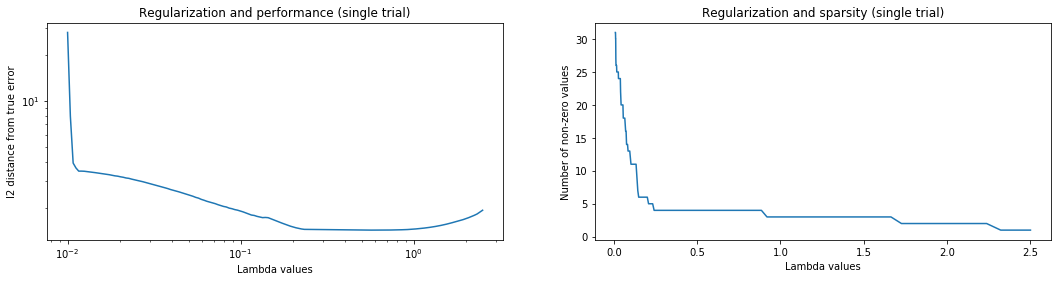

In [10]:

myfig = plt.figure(figsize=(18,4))
ax_dist = myfig.add_subplot(1, 2, 1)
plt.ylabel("l2 distance from true error")
plt.xlabel("Lambda values")
plt.title("Regularization and performance (single trial)")
ax_dist.set_yscale('log')
ax_dist.set_xscale('log')

ax_spar = myfig.add_subplot(1, 2, 2)
plt.ylabel("Number of non-zero values")
plt.xlabel("Lambda values")
plt.title("Regularization and sparsity (single trial)")

ax_dist.plot(todo_lambda, dist_overlam)
ax_spar.plot(todo_lambda, spar_overlam)

plt.show()

Note the following points here:

- Taking a larger $\lambda$ value indeed leads to sparser solutions; a larger value implicitly specifies tigher $\ell_{1}$ (and $\ell_{0}$) norm constraints.

- There is a clear tradeoff between __bias__ and __variance__ of the learning algorithm here. Too tight a constraint means that the correct solution may not be in the feasible region, a bias. Too loose a constraint leaves too many parameters to specify given relatively few observations, large variance over the random draw of the sample.

### Exercises:

1. In the above example, we start with *small* $\lambda$ values and work up to larger values, utilizing warm starts along the way. Try reversing the order (starting large). Does the best lambda value tend to change depending on the direction?

1. Try running the algorithm "fresh" for each new $\lambda$ candidate, without using warm starts (i.e., use the same pre-fixed `w_init` every time). Does performance degrade? Does the optimal $\lambda$ value change?

1. One common strategy for constructing the grid is to set the sequence $(\lambda_{0},\ldots,\lambda_{k})$ such that the values are evenly spaced on a log scale, i.e., $\log\lambda_{i} - \log\lambda_{i-1} = c > 0$, a constant for all $i$. Extend the above code such that the minimum and maximum parameter values take the following standard values (Bühlmann, and Van De Geer, 2011): writing $x_{j}$ for the $j$th column of the design matrix, $x_{(j)} = (x_{1,j},\ldots,x_{n,j})$, and $y=(y_{1},\ldots,y_{n})$,

\begin{align}
\lambda_{0} = 1/n, \quad \lambda_{k} = \max \left\{|\langle y, x_{(j)}\rangle|/n:j=1,\ldots,d \right\}.
\end{align}

The previous example was run on just a single set of randomly generated data. To better capture the overall trends, we next run multiple trials, generating new data each time. Performance is measured each time, and the average and variance over trials are then computed.

In [11]:

todo_lambda = np.flipud(np.logspace(start=math.log10(1/100), stop=math.log10(2.5), num=150))
num_lambda = todo_lambda.size
num_trials = 10

dist_overtrials = np.zeros(num_lambda*num_trials, dtype=np.float64).reshape((num_trials, num_lambda))
spar_overtrials = np.zeros(num_lambda*num_trials, dtype=np.float64).reshape((num_trials, num_lambda))

dist_overlam = np.zeros(todo_lambda.size, dtype=np.float64) # store performance stats for each lambda setting.
spar_overlam = np.zeros(todo_lambda.size, dtype=np.float64)

for tr in range(num_trials):

    data_info = dp.NoisyOpt_SmallSparse()
    mod = mp.model(data_info)
    w_init = mod.w_initialize()

    # Iterate over the lambda values once, for a single candidate.
    print("Trial number", tr, "... Working.")
    for i in range(todo_lambda.size):
    
        # Initialize and execute the algorithm.
        al = Algo_LASSO_CD(w_init=w_init,\
                           t_max=20*w_init.size,\
                           lam_l1=todo_lambda[i],\
                           verbose=False)
        for mystep in al:
            al.update(model=mod)
    
        # Check performance.
        w_est = al.w

        dist_overlam[i] = mod.evalDist(w_est)
        spar_overlam[i] = mod.evalSparsity(w_est)
    
        # Update the initializer to the most current observation.
        w_init = w_est
    
    dist_overtrials[tr,:] = dist_overlam
    spar_overtrials[tr,:] = spar_overlam
    
dist_ave = np.mean(dist_overtrials, axis=0)
dist_sd = np.std(dist_overtrials, axis=0)
spar_ave = np.mean(spar_overtrials, axis=0)
spar_sd = np.std(dist_overtrials, axis=0)

dist_argmin = todo_lambda[np.argmin(dist_ave)] # lambda realizing smallest distance.

print("Done.")

Trial number 0 ... Working.
Trial number 1 ... Working.
Trial number 2 ... Working.
Trial number 3 ... Working.
Trial number 4 ... Working.
Trial number 5 ... Working.
Trial number 6 ... Working.
Trial number 7 ... Working.
Trial number 8 ... Working.
Trial number 9 ... Working.
Done.


Let's now visualize these results.

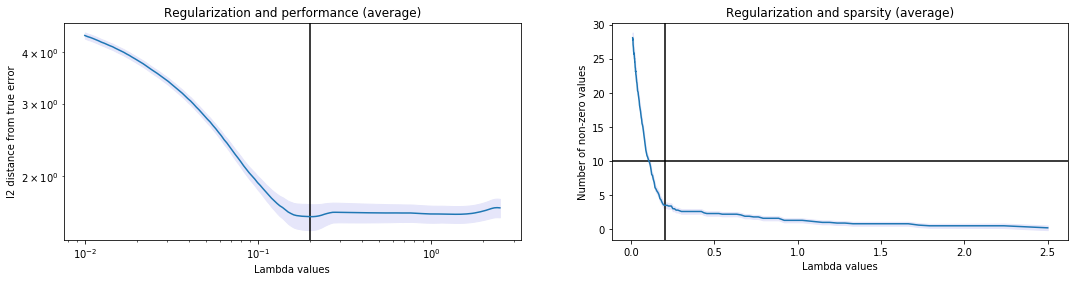

In [12]:
myfig = plt.figure(figsize=(18,4))

ax_dist = myfig.add_subplot(1, 2, 1)
plt.ylabel("l2 distance from true error")
plt.xlabel("Lambda values")
plt.title("Regularization and performance (average)")
ax_dist.set_yscale('log')
ax_dist.set_xscale('log')
plt.axvline(x=dist_argmin, color="black")

logerr = dist_sd / (math.log(10)*dist_ave) # for error bars when using log scale
plt.fill_between(todo_lambda, dist_ave-logerr,  
                 dist_ave+logerr, color="lavender")
ax_dist.plot(todo_lambda, dist_ave)

ax_spar = myfig.add_subplot(1, 2, 2)
plt.ylabel("Number of non-zero values")
plt.xlabel("Lambda values")
plt.title("Regularization and sparsity (average)")
plt.axvline(x=dist_argmin, color="black")
plt.axhline(y=10, color="black")

err = spar_sd # for error bars in original scale
plt.fill_between(todo_lambda, spar_ave-err,  
                 spar_ave+err, color="lavender")
ax_spar.plot(todo_lambda, spar_ave)

plt.show()

Note that the best distance is achieved, on average, at the correct sparsity level, which is precisely the behaviour that we should expect.

### Exercises:

1. How does performance change when more/less loops are carried out?

1. As before, try with and without warm starts, evaluate the change in average performance, variance over trials, and the average sparsity of the best estimate.

1. (Bonus) Add `w_old`, `thres` and `diff` attributes to `Algo_LASSO_CD`. Every time we carry out `w.size` (that is, $d$) iterations, set `diff` to the norm of the difference between `w` and `w_old`. If `diff` is less than `thres` (a parameter we must set), then terminate.

1. (Bonus) Following the above `thres`-based termination conditions, how many iterations does it typically take to converge? Does this depend on the value of $\lambda$?

1. (Bonus) If we perform many loops, for most of the time many $w_{j}$ values will likely be zero. A different strategy for looping over the indices is to *ignore* all coordinates once they have taken on a zero value. Implement this strategy (re-define `idx` on the fly). How does performance compare with the original circulating approach? What about computation time?

___

<a id="robust"></a>
## Robust sparse regression

### End of lesson: paste any routines to be re-used in the `scripts/AlgoSparseReg.py` file.

## References:

- Bühlmann, Peter, and Sara Van De Geer. Statistics for high-dimensional data: methods, theory and applications. Springer Science & Business Media, 2011.
- Haxby, James V., et al. "Distributed and overlapping representations of faces and objects in ventral temporal cortex." Science 293.5539 (2001): 2425-2430.